In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from einops import rearrange, reduce, repeat
import matplotlib.pyplot as plt

In [3]:
b,c,h,w,d = 3, 10,4,4,4
q = torch.randn(b,c,h,w,d)
k = torch.randn(b,c,h,w,d)
v = torch.randn(b,c,h,w,d)
q.shape

torch.Size([3, 10, 4, 4, 4])

In [4]:
rearrange(q, "b c h w d -> (b c) h w d ").shape

torch.Size([30, 4, 4, 4])

In [5]:
q = rearrange(q, "b c h w d -> b (h w d) c ")
k = rearrange(k, "b c h w d -> b c (h w d)")
# w.shape

In [6]:
wei = (q @ k)
wei.shape

torch.Size([3, 64, 64])

In [7]:
# q is product of spatial dimensions: h*w*d
# so w is a matrix representing attention between each *voxel*
w2 = torch.einsum("b q c, b c k -> b q k", q,k)
w2.shape

torch.Size([3, 64, 64])

In [9]:
torch.allclose(wei,w2)

True

In [11]:
class AttnBlock(nn.Module):
  """Channel-wise self-attention block."""
  def __init__(self, channels):
    super().__init__()
    torch.random.manual_seed(42)
    self.GroupNorm_0 = nn.GroupNorm(num_groups=1, num_channels=channels, eps=1e-6)
    self.NIN_0 = nn.Conv2d(channels, channels, kernel_size=1)
    self.NIN_1 = nn.Conv2d(channels, channels, kernel_size=1)
    self.NIN_2 = nn.Conv2d(channels, channels, kernel_size=1)
    self.NIN_3 = nn.Conv2d(channels, channels, kernel_size=1)

  def forward(self, x):
    B, C, H, W = x.shape
    h = self.GroupNorm_0(x)
    q = self.NIN_0(h)
    k = self.NIN_1(h)
    v = self.NIN_2(h)

    w = torch.einsum('bchw,bcij->bhwij', q, k) * (int(C) ** (-0.5))
    w = torch.reshape(w, (B, H, W, H * W))
    w = F.softmax(w, dim=-1)
    # plt.imshow(w[0].detach().numpy().reshape(-1,H*W))
    # plt.show()
    w = torch.reshape(w, (B, H, W, H, W))
    h = torch.einsum('bhwij,bcij->bchw', w, v)
    # plt.imshow(h[0].detach().numpy().reshape(H*W,C))
    h = self.NIN_3(h)
    return h

In [12]:
class MyAttnBlock(nn.Module):
  """Channel-wise self-attention block."""
  def __init__(self, channels):
    super().__init__()
    torch.random.manual_seed(42)
    self.GroupNorm_0 = nn.GroupNorm(num_groups=1, num_channels=channels, eps=1e-6)
    self.NIN_0 = nn.Conv2d(channels, channels, kernel_size=1)
    self.NIN_1 = nn.Conv2d(channels, channels, kernel_size=1)
    self.NIN_2 = nn.Conv2d(channels, channels, kernel_size=1)
    self.NIN_3 = nn.Conv2d(channels, channels, kernel_size=1)
    self.scale = int(channels) ** (-0.5)

  def forward(self, x):
    B, C, H, W = x.shape
    h = self.GroupNorm_0(x)
    q = self.NIN_0(h)
    k = self.NIN_1(h)
    v = self.NIN_2(h)

    q = rearrange(q, "b c h w -> b c (h w)")
    k = rearrange(k, "b c h w -> b c (h w)")
    v = rearrange(v, "b c h w -> b c (h w)")

    w = torch.einsum('b c q, b c k -> b q k', q, k) * self.scale
    w = F.softmax(w, dim=-1)
    # plt.imshow(w[0].detach().numpy())
    # plt.show()
    # Note how k is used for both inputs
    # This is important as it tells einops to expect the *same* dimensions
    # so e.g. this did NOT work: "bqk, b c *v* -> bcq"
    h = torch.einsum("bqk,bck->bcq", w,v)
    # print(h.shape)
    h = rearrange(h, "b c (h w) -> b c h w", h=H, w=W)
    # h = torch.reshape(h, (B, C, H, W))
    # plt.imshow(h[0].detach().numpy().reshape(H*W,C))
    # print(h.shape)
    h = self.NIN_3(h)

    return h

In [13]:
b,c,h,w,d = 3, 8, 4,4,4
x = torch.randn(b,c,h,w)
attention = torch.jit.script(AttnBlock(c))
attentionpp = MyAttnBlock(c)

In [14]:
%%time
y1 = attention(x)

CPU times: user 31.5 ms, sys: 2.61 ms, total: 34.1 ms
Wall time: 33.3 ms


In [15]:
%%time
y2 = attentionpp(x)

CPU times: user 1.11 ms, sys: 768 µs, total: 1.88 ms
Wall time: 1.18 ms


In [16]:
assert torch.allclose(y1, y2)

In [17]:
from einops.layers.torch import Rearrange

class AttnBlock3d(nn.Module):
  """Channel-wise 3D self-attention block."""
  def __init__(self, channels):
    super().__init__()
    torch.random.manual_seed(42)
    self.norm = nn.GroupNorm(num_groups=1, num_channels=channels, eps=1e-6)
    self.qkv = nn.Conv3d(channels, channels*3, kernel_size=1)
    self.spatial_flatten = Rearrange(pattern="b c h w d -> b c (h w d)")
    self.proj = nn.Conv3d(channels, channels, kernel_size=1)
    self.scale = int(channels) ** (-0.5)

  def forward(self, x):
    B, C, H, W, D = x.shape
    q,k,v = self.qkv(self.norm(x)).chunk(3, dim=1)

    q = self.spatial_flatten(q)
    k = self.spatial_flatten(k)
    v = self.spatial_flatten(v)

    w = torch.einsum('b c q, b c k -> b q k', q, k) * self.scale
    w = F.softmax(w, dim=-1)
    h = torch.einsum("b q k , b c k -> b c q", w,v)
    h = torch.reshape(h, (B, C, H, W, D))
    h = self.proj(h)

    return x + h

In [18]:
b,c,h,w,d = 5, 8, 4,4,4
x = torch.randn(b,c,h,w, d)
attention3d = AttnBlock3d(c)
jitted_attention3d = torch.jit.script(AttnBlock3d(c))

In [19]:
qkv = nn.Conv3d(c, c*3, kernel_size=1)

In [20]:
%%time
q,k,v = qkv(x).reshape(b,c,3,h,w,d).unbind(dim=2)

CPU times: user 472 µs, sys: 273 µs, total: 745 µs
Wall time: 515 µs


In [21]:
%%time
q,k,v = qkv(x).chunk(3, dim=1)

CPU times: user 184 µs, sys: 47 µs, total: 231 µs
Wall time: 193 µs


In [22]:
q.shape,k.shape,v.shape

(torch.Size([5, 8, 4, 4, 4]),
 torch.Size([5, 8, 4, 4, 4]),
 torch.Size([5, 8, 4, 4, 4]))

In [23]:
%%time
y = attention3d(x)

CPU times: user 1.06 ms, sys: 777 µs, total: 1.83 ms
Wall time: 1.06 ms


In [24]:
%%time
y = jitted_attention3d(x)

CPU times: user 17.3 ms, sys: 1.45 ms, total: 18.8 ms
Wall time: 17.2 ms


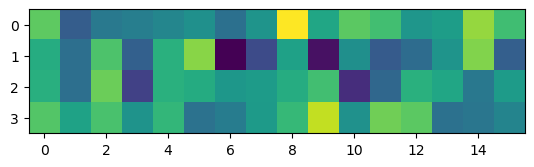

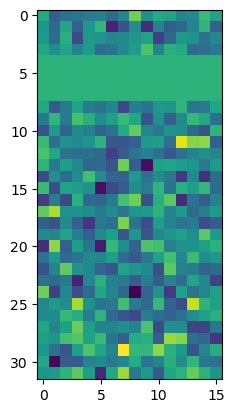

In [25]:
# plot 3D heatmaps
y[0,1] = 1.0
plt.imshow(y[0,0].reshape(4,16).detach().numpy())
plt.show()
plt.imshow(y[0].view(8*4 ,16).detach().numpy())


In [34]:
loss = (x - y)**2
loss.mean().backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

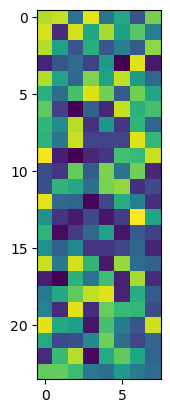

In [33]:
plt.imshow(jitted_attention3d.qkv.weight.detach()[...,0,0,0])